### 1、任务详情

【任务1 - 数据分析（2天）】
- 数据类型的分析
- 无关特征删除
- 数据类型转换
- 缺失值处理
- 以及你能想到和借鉴的数据分析处理
- 预测贷款用户是否会逾期。表格中 "status" 是结果标签：0表示未逾期，1表示逾期
- 要求：数据切分方式 - 三七分，其中测试集30%，训练集70%，随机种子设置为2018

In [264]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [265]:
data = pd.read_csv('data.csv')

In [266]:
data_bak = data.copy()

### 2、数据简介

In [267]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Columns: 90 entries, Unnamed: 0 to loans_latest_day
dtypes: float64(71), int64(13), object(6)
memory usage: 3.3+ MB


In [268]:
def get_data_msg(data):
    data_des = data.describe(percentiles=[], include='all').T
    data_des['null'] = data.shape[0] - data_des['count']
    data_des['miss_%'] = data_des['null'] / data.shape[0]
    data_des['dtype'] = data.dtypes
    return data_des.sort_values('null', ascending=False)
get_data_msg(data).head()

,count,unique,top,freq,mean,std,min,50%,max,null,miss_%,dtype
student_feature,1756,NaN,NaN,NaN,1.00114,0.0337387,1,1,2,2998,0.630627,float64
cross_consume_count_last_1_month,4328,NaN,NaN,NaN,0.642329,2.34323,0,0,69,426,0.0896088,float64
latest_six_month_apply,4450,NaN,NaN,NaN,12.3643,9.27498,0,10,80,304,0.0639462,float64
latest_one_month_apply,4450,NaN,NaN,NaN,4.32944,4.52552,0,3,38,304,0.0639462,float64
latest_query_time,4450,207,4/14/2018,423,NaN,NaN,NaN,NaN,NaN,304,0.0639462,object


数据集有84个数值型特征以及6个非数值型特征，其中数值型特征有71个float型和13个int型

其中student_feature特征有大量缺失值，另外部分特征有约300个左右的缺失值。

### 3、无关数据处理

In [269]:
# ['custid','trade_no','id_name','Unnamed: 0'] 这些与数据没有直接关系
data.drop(['custid','trade_no','id_name','Unnamed: 0'], axis=1, inplace=True)

In [270]:
# 其次还有整个属性列只有一个属性值的列
data_msg = get_data_msg(data)
data.drop(data_msg[data_msg['unique'] == 1].index.tolist(), axis=1, inplace=True)

In [271]:
# 特征分离
data_obj = data.select_dtypes(include='object').copy()
data_num = data.select_dtypes(include='number').copy()

### 4、缺失值处理

- 数值型数据

In [272]:
get_data_msg(data_num).head()
# student_feature缺失率大于50%，其他基本在10%以下
# 处理方式
# student_feature列删除
# 其他中中位数填补

,count,mean,std,min,50%,max,null,miss_%,dtype
student_feature,1756.0,1.001139,0.033739,1.0,1.0,2.0,2998.0,0.630627,float64
cross_consume_count_last_1_month,4328.0,0.642329,2.343228,0.0,0.0,69.0,426.0,0.089609,float64
latest_one_month_apply,4450.0,4.329438,4.525521,0.0,3.0,38.0,304.0,0.063946,float64
apply_score,4450.0,576.632584,51.167375,450.0,549.0,687.0,304.0,0.063946,float64
apply_credibility,4450.0,75.998876,4.168916,50.0,76.0,93.0,304.0,0.063946,float64


In [273]:
data_num = data_num.drop(labels='student_feature', axis=1)
data_num = data_num.fillna(data_num.median())
get_data_msg(data_num).head()

,count,mean,std,min,50%,max,null,miss_%,dtype
low_volume_percent,4754.0,0.021801,0.041519,0.0,0.01,1.0,0.0,0.0,float64
middle_volume_percent,4754.0,0.901319,0.144831,0.0,0.96,1.0,0.0,0.0,float64
latest_one_month_loan,4754.0,0.905553,1.466836,0.0,0.00,15.0,0.0,0.0,float64
loans_cash_count,4754.0,8.043542,5.210809,0.0,7.00,31.0,0.0,0.0,float64
consfin_org_count_behavior,4754.0,4.686580,2.885609,0.0,4.00,18.0,0.0,0.0,float64


- 非数值型数据

In [274]:
get_data_msg(data_obj).head()

,count,unique,top,freq,null,miss_%,dtype
latest_query_time,4450,207,4/14/2018,423,304,0.0639462,object
loans_latest_time,4457,232,5/3/2018,134,297,0.0624737,object
reg_preference_for_trad,4752,5,一线城市,3403,2,0.000420698,object


    - 日期型数据['latest_query_time','loans_latest_time']

In [275]:
# 先填充众数
data_obj[['latest_query_time','loans_latest_time']] = data_obj[['latest_query_time','loans_latest_time']]\
    .fillna(data_obj[['latest_query_time','loans_latest_time']].mode().iloc[0,:])

In [276]:
# 再拆分，以免出现日期越界的情况
data_date = pd.DataFrame()
for col in ['latest_query_time','loans_latest_time']:
    data_date['%s_year'%col] = pd.to_datetime(data_obj[col]).dt.year.astype('int32')
    data_date['%s_month'%col] = pd.to_datetime(data_obj[col]).dt.month.astype('int32')
    data_date['%s_day'%col] = pd.to_datetime(data_obj[col]).dt.day.astype('int32')

    - reg_preference_for_trad特征

In [277]:
# 与其他数据相比，这个特征只有两个缺失值，可以选择用众数填补
data_obj['reg_preference_for_trad'].fillna(data_obj['reg_preference_for_trad'].describe()['top'], inplace=True)

In [278]:
# one-hot编码
data_loca = pd.get_dummies(data_obj['reg_preference_for_trad'])

### 5、合并特征

In [279]:
data_tra = pd.concat([data_num, data_date, data_loca], axis=1)

### 6、数值型数据归一化

In [280]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tra_cols = data_num.columns.tolist()
tra_cols.remove('status') # 个人觉得不要把标签也归一化了
data_tra[tra_cols] = scaler.fit_transform(data_tra[tra_cols])

In [281]:
data_tra.head()

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,latest_query_time_month,latest_query_time_day,loans_latest_time_year,loans_latest_time_month,loans_latest_time_day,一线城市,三线城市,二线城市,其他城市,境外
0,-0.284251,0.612374,-0.494499,-0.019099,-1.292452,-0.308087,-0.112363,-0.088968,0.258090,0.360860,...,4,25,2018,4,19,1,0,0,0,0
1,-0.043372,0.267106,0.015242,-0.018551,0.993418,0.544138,0.334643,0.043178,-0.470508,1.484325,...,5,3,2018,5,5,1,0,0,0,0
2,0.438384,0.405213,-0.494499,-0.018955,0.993418,-1.477693,-1.006374,1.717020,0.015224,-1.886068,...,5,5,2018,5,1,1,0,0,0,0
3,-0.525129,0.405213,0.015242,-0.020208,-1.190857,2.419034,1.005152,-0.661598,-0.956239,0.360860,...,5,5,2018,5,3,0,1,0,0,0
4,-0.284251,0.612374,-0.494499,-0.019733,0.993418,-1.119171,-1.006374,1.628923,1.229553,-1.886068,...,4,15,2018,1,7,1,0,0,0,0


### 7、数据EDA

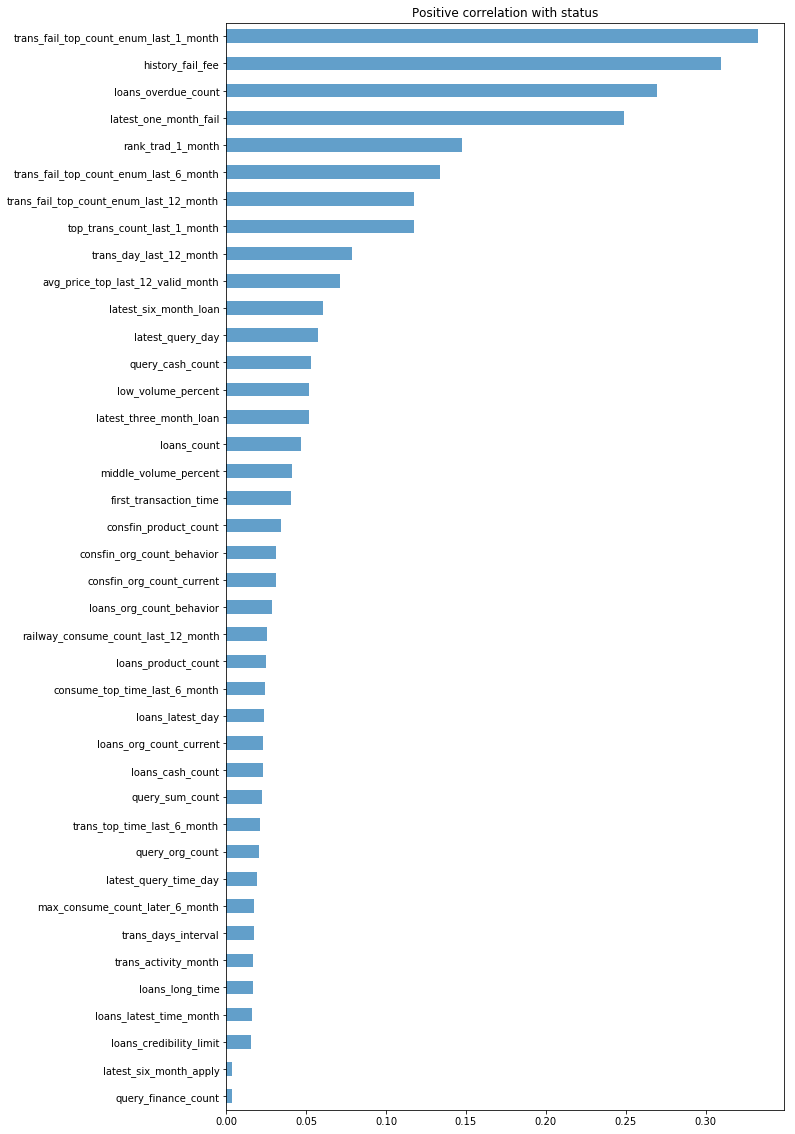

In [322]:
# 90个特征也是够烦的。。
# 先保存一下处理过后的数据
# data_tra.to_csv('data_.csv')

# 过滤了已经拆分的location
data_eda = data_tra.iloc[:,:-5]
status_corr = data_eda.corr()['status'].drop('status', axis=0)
status_corr[status_corr>0].sort_values().plot.barh(figsize=(10,20), title='Positive correlation with status', alpha=0.7)